# Summary of work

This notebook explores how closely the spec2vec vectors within each group resemble eachother using the spec2vec built-in cosine similarity function. This to compare how much of the internal similarity in the molecular structures is captured by spec2vec.

# Load libraries and data

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spec2vec
import gensim

from scipy.stats import percentileofscore
from scipy.spatial.distance import cdist
from sklearn.preprocessing import scale
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from processing import get_ids_for_unique_inchikeys

# Specify directories
data_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Data/"
embedding_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Embeddings/"
model_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Model/"
plot_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Plots/"

# Define functions
def cosine_similarity_for_groups(metadata_df, var, model, spectrum_documents, min_class_size=50):
    class_count = metadata_df[var].value_counts(ascending=False)
    selected_classes = class_count[class_count>=min_class_size]
    print(len(selected_classes), "classes exceed minimum class size")
    
    cosine_array = []
    for group in selected_classes.index:
        selection = metadata_df[metadata_df[var] == group]
        document_selection = [spectrum_documents[i] for i in selection.index]
        cosine_matrix = model.matrix(document_selection, document_selection, is_symmetric=True)
        cosine_triangle = cosine_matrix[np.triu_indices(n=len(selection))]
        cosine_array += [cosine_triangle]
    return selected_classes, cosine_array

def flatten(t):
    return [item for sublist in t for item in sublist]

def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center", fontsize = 8) 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [3]:
# Load original spectra file
spectra = pd.read_pickle(data_dir+"ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v.pickle")

# Get pretrained model
pretrained_model = gensim.models.Word2Vec.load(model_dir+"ALL_GNPS_210409_positive_cleaned_spec2vec_embedding_iter_15.model")
model = spec2vec.Spec2Vec(pretrained_model, intensity_weighting_power=0.5, allowed_missing_percentage=60)

In [4]:
# Load the class predictions for each inchikey
inchikey_classifications = pd.read_csv(data_dir+"ALL_GNPS_210409_positive_processed_annotated_CF_NPC_classes.txt", sep = "\t")
inchikey_classifications.rename(columns = {"inchi_key": "inchikey"}, inplace = True) 

In [2]:
# Load metadata of inchikey-annotated spectra
spectrum_metadata = pd.read_csv(data_dir+"GNPS_210409 Metadata inchi annotated spectra.csv", sep = "\t")

# Prep data

In [7]:
# Subset the spectra to only the spectra with inchikeys
inchi_spectra = [spectra[i] for i in spectrum_metadata["spectrum_index"]] 
print(len(inchi_spectra), "out of", len(spectra), "spectra are annotated with an Inchikey")

# We retrieve the IDs of spectra with unique planar Inchikeys
unique_inchi = get_ids_for_unique_inchikeys(inchi_spectra)
print(f'{len(unique_inchi)} out of {len(inchi_spectra)} annotated spectra have a unique Inchikey')

# Quick check to see that the spectra and spectrum_metadata match up
print("Spectra and metadata match:", inchi_spectra[17000].get("spectrum_id") == spectrum_metadata["ID"][17000])

187152 out of 199780 spectra are annotated with an Inchikey
16360 out of 187152 annotated spectra have a unique Inchikey
Spectra and metadata match: True


In [8]:
# Retrieve SpectrumDocuments
spectrum_documents = [spec2vec.SpectrumDocument(s, n_decimals=2) for i, s in enumerate(inchi_spectra)]

In [9]:
del(spectra, inchi_spectra)

# Cosine similarity
Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space. It is defined to equal the cosine of the angle between them, which is also the same as the inner product of the same vectors normalized to both have length 1. The cosine of 0° is 1, and it is less than 1 for any angle in the interval (0, π] radians.

# NPClassifier classes

In [129]:
# Get Jaccard similarities
npc_classes, cosine_npc_class = cosine_similarity_for_groups(metadata_df = spectrum_metadata.iloc[unique_inchi], var="npc_class_results", model = model,
                                                             spectrum_documents = spectrum_documents, min_class_size=50)
# Which percentage of spectrum pairs has a similarity higher than the threshold value of 0.5?
npc_class_percentile_scores = 100-pd.Series([percentileofscore(group, 0.5, kind = "rank") for group in cosine_npc_class], index = npc_classes.index).sort_values()

69 classes exceed minimum class size


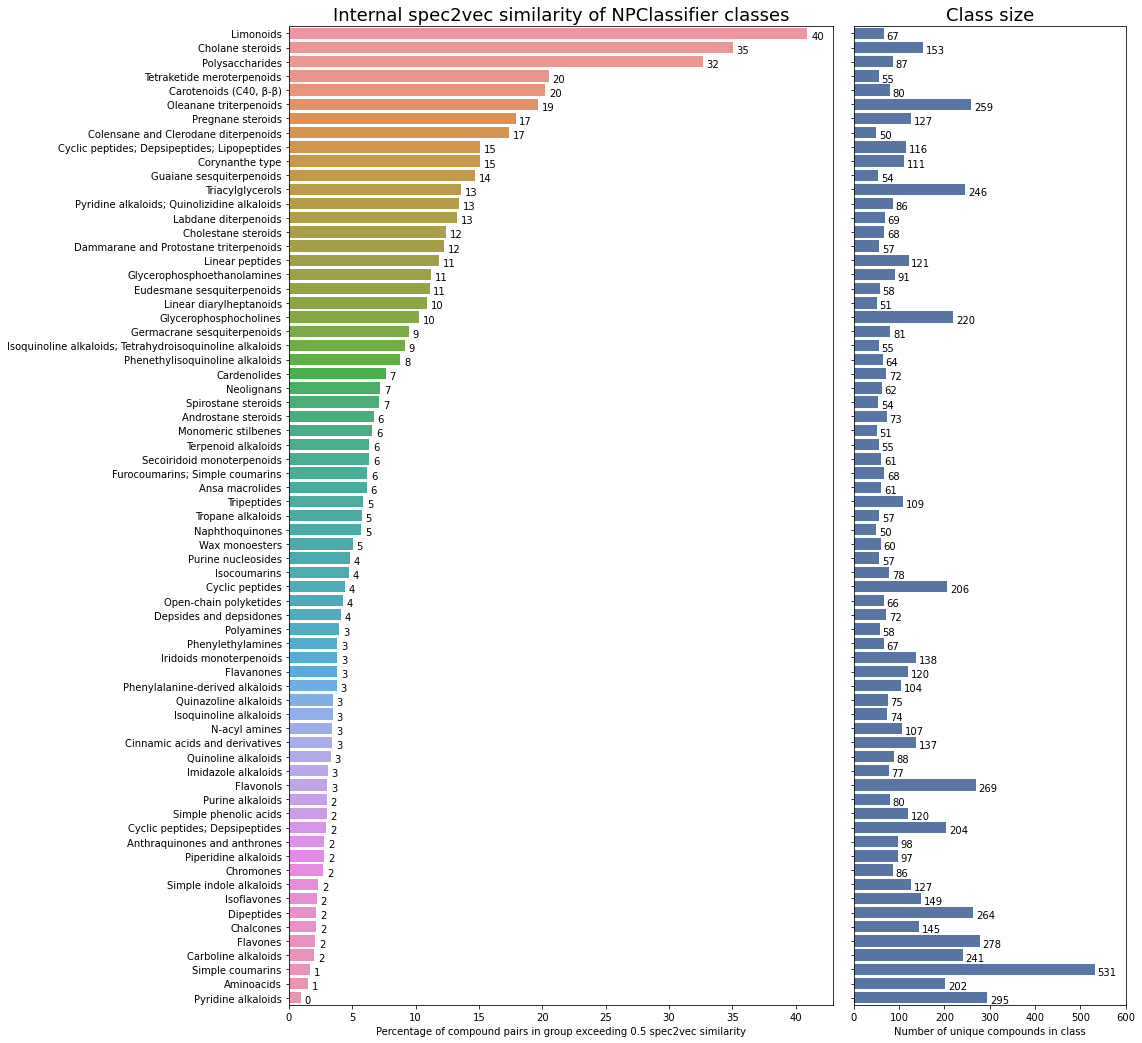

In [53]:
npc_classes = npc_classes.reindex(npc_class_percentile_scores.index)

f, axes = plt.subplots(1, 2, figsize=(15, 18), gridspec_kw={'width_ratios': [2, 1]})
f.subplots_adjust(hspace=0.025, wspace=0.05)

fig1 = sns.barplot(x = npc_class_percentile_scores.values.flatten(), y = npc_class_percentile_scores.index, ax = axes[0])
fig1.set_xlabel('Percentage of compound pairs in group exceeding 0.5 spec2vec similarity')
fig1.set_title("Internal spec2vec similarity of NPClassifier classes", fontsize=18)
show_values_on_bars(fig1, "h", 0.3)

fig2 = sns.barplot(x = npc_classes.values, y = npc_classes.index, ax = axes[1], color = "#4C72B0")
fig2.set_title("Class size", fontsize = 18)
fig2.set_xlabel("Number of unique compounds in class")
fig2.set_xlim(0,600)
show_values_on_bars(fig2, "h", 6)
fig2.set_yticklabels([]);

plt.savefig(plot_dir+"Internal spec2vec similarity with 0.5 threshold - NPClassifier classes.png")

# Classyfire superclasses

In [115]:
# Get Jaccard similarities
cf_superclasses, cosine_cf_superclass = cosine_similarity_for_groups(metadata_df = spectrum_metadata.iloc[unique_inchi], var="cf_superclass", model = model,
                                                           spectrum_documents = spectrum_documents, min_class_size=50)

11 classes exceed minimum class size


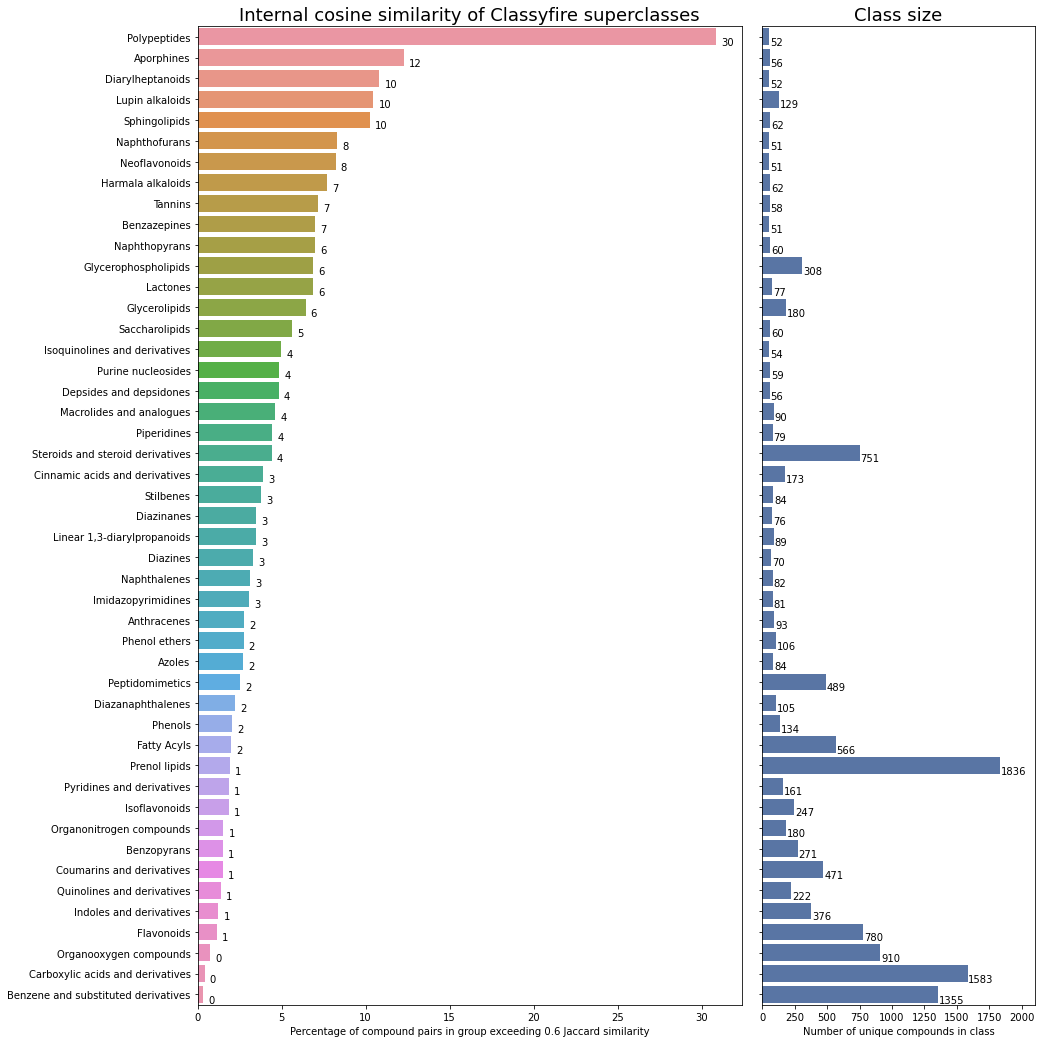

In [117]:
cf_superclasses = cf_superclasses.reindex(cf_superclass_percentile_scores.index)

f, axes = plt.subplots(1, 2, figsize=(15, 18), gridspec_kw={'width_ratios': [2, 1]})
f.subplots_adjust(hspace=0.025, wspace=0.05)

fig1 = sns.barplot(x = cf_class_percentile_scores.values, y = cf_class_percentile_scores.index, ax = axes[0])
fig1.set_xlabel('Percentage of compound pairs in group exceeding 0.6 Jaccard similarity')
fig1.set_title("Internal cosine similarity of Classyfire superclasses", fontsize=18)
show_values_on_bars(fig1, "h", 0.3)

fig2 = sns.barplot(x = cf_classes.values, y = cf_classes.index, ax = axes[1], color = "#4C72B0")
fig2.set_title("Class size", fontsize = 18)
fig2.set_xlabel("Number of unique compounds in class")
fig2.set_xlim(0,2100)
show_values_on_bars(fig2, "h", 6)
fig2.set_yticklabels([]);

#plt.savefig(plot_dir+"Internal cosine similarity with 0.5 threshold - Classyfire superclasses.svg")

# Classyfire classes

In [100]:
# Get Jaccard similarities
cf_classes, cosine_cf_class = cosine_similarity_for_groups(metadata_df = spectrum_metadata.iloc[unique_inchi], var="cf_class", model = model,
                                                           spectrum_documents = spectrum_documents, min_class_size=50)

# Which percentage of spectrum pairs has a similarity higher than the threshold value of 0.5?
cf_class_percentile_scores = 100-pd.Series([percentileofscore(group, 0.5, kind = "rank") for group in cosine_cf_class], index = cf_classes.index).sort_values()

47 classes exceed minimum class size


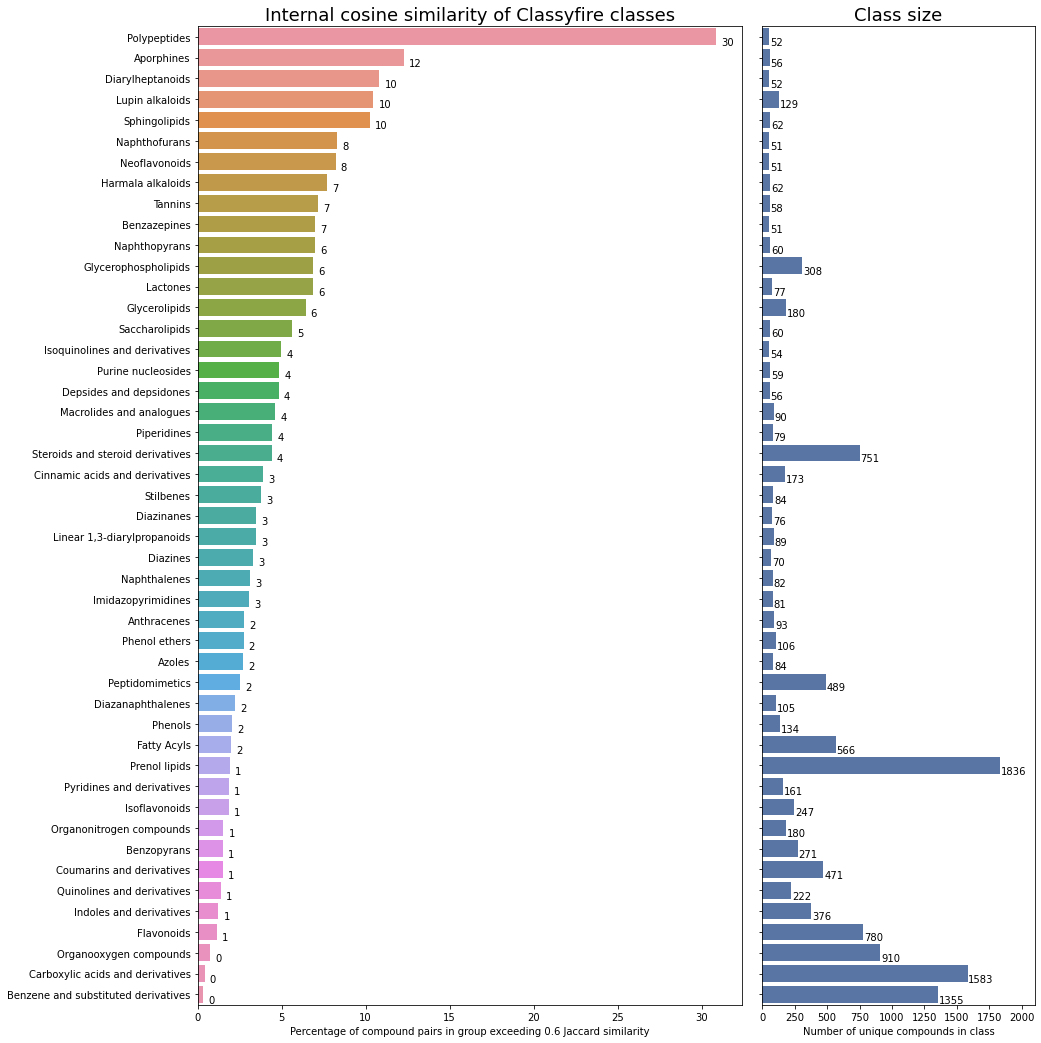

In [105]:
cf_classes = cf_classes.reindex(cf_class_percentile_scores.index)

f, axes = plt.subplots(1, 2, figsize=(15, 18), gridspec_kw={'width_ratios': [2, 1]})
f.subplots_adjust(hspace=0.025, wspace=0.05)

fig1 = sns.barplot(x = cf_class_percentile_scores.values, y = cf_class_percentile_scores.index, ax = axes[0])
fig1.set_xlabel('Percentage of compound pairs in group exceeding 0.6 Jaccard similarity')
fig1.set_title("Internal cosine similarity of Classyfire classes", fontsize=18)
show_values_on_bars(fig1, "h", 0.3)

fig2 = sns.barplot(x = cf_classes.values, y = cf_classes.index, ax = axes[1], color = "#4C72B0")
fig2.set_title("Class size", fontsize = 18)
fig2.set_xlabel("Number of unique compounds in class")
fig2.set_xlim(0,2100)
show_values_on_bars(fig2, "h", 6)
fig2.set_yticklabels([]);

#plt.savefig(plot_dir+"Internal cosine similarity with 0.5 threshold - Classyfire classes.svg")

# Classyfire subclasses

In [110]:
# Get Jaccard similarities
cf_subclasses, cosine_cf_subclass = cosine_similarity_for_groups(metadata_df = spectrum_metadata.iloc[unique_inchi], var="cf_subclass", model = model,
                                                                 spectrum_documents = spectrum_documents, min_class_size=50)

# Which percentage of spectrum pairs has a similarity higher than the threshold value of 0.5?
cf_subclass_percentile_scores = 100-pd.Series([percentileofscore(group, 0.5, kind = "rank") for group in cosine_cf_subclass], index = cf_subclasses.index).sort_values()

52 classes exceed minimum class size


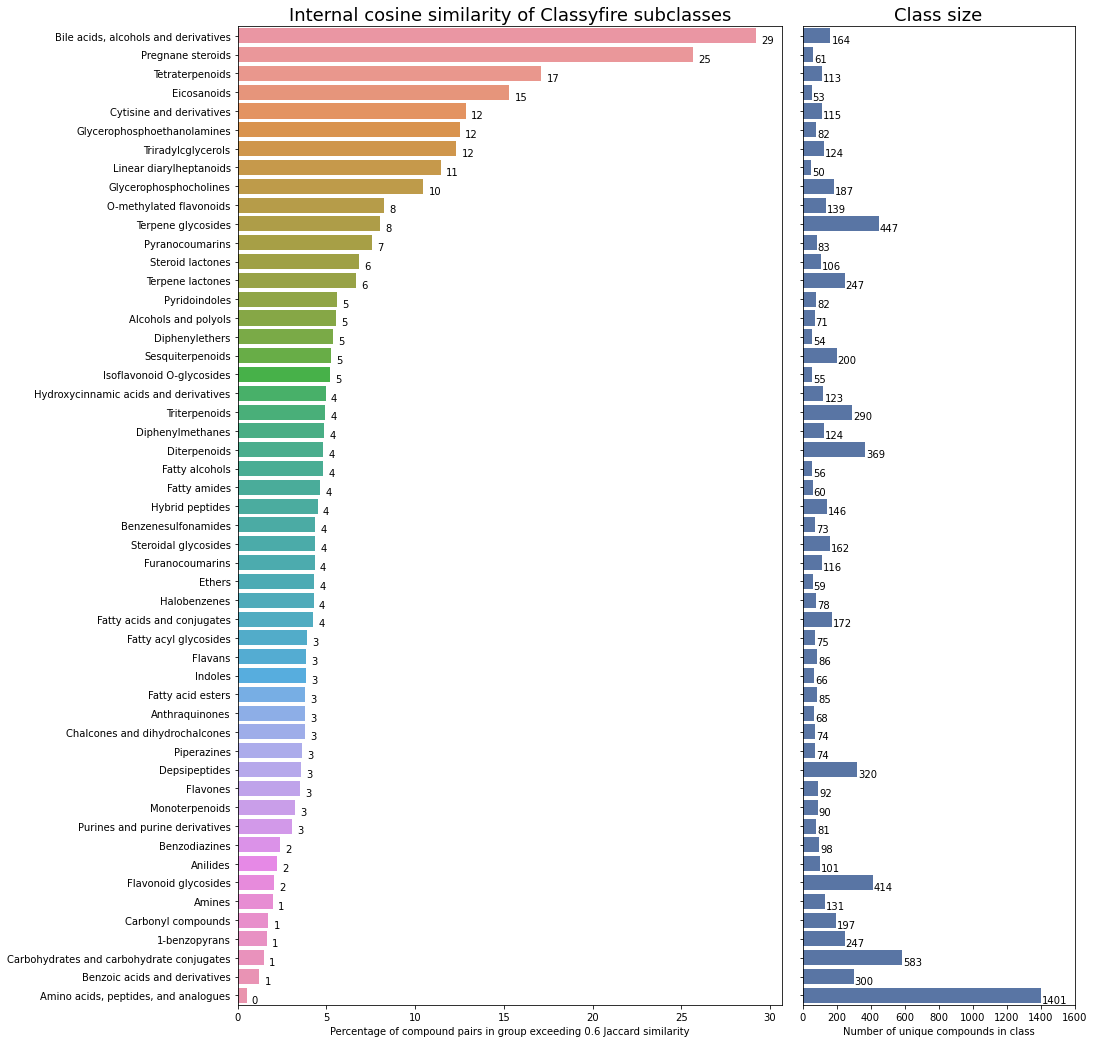

In [114]:
cf_subclasses = cf_subclasses.reindex(cf_subclass_percentile_scores.index)

f, axes = plt.subplots(1, 2, figsize=(15, 18), gridspec_kw={'width_ratios': [2, 1]})
f.subplots_adjust(hspace=0.025, wspace=0.05)

fig1 = sns.barplot(x = cf_subclass_percentile_scores.values, y = cf_subclass_percentile_scores.index, ax = axes[0])
fig1.set_xlabel('Percentage of compound pairs in group exceeding 0.6 Jaccard similarity')
fig1.set_title("Internal cosine similarity of Classyfire subclasses", fontsize=18)
show_values_on_bars(fig1, "h", 0.3)

fig2 = sns.barplot(x = cf_subclasses.values, y = cf_subclasses.index, ax = axes[1], color = "#4C72B0")
fig2.set_title("Class size", fontsize = 18)
fig2.set_xlabel("Number of unique compounds in class")
fig2.set_xlim(0,1600)
show_values_on_bars(fig2, "h", 6)
fig2.set_yticklabels([]);

#plt.savefig(plot_dir+"Internal cosine similarity with 0.5 threshold - Classyfire subclasses.svg")

# Which classification method results in the largest high similarity groups?

In [139]:
# Determine number of compounds in the high similarity groups
classifications = ["NPClassifier classes", "Classyfire superclasses", "Classyfire classes", "Classyfire subclasses"]
thresholds = [10, 20, 30, 40 , 50 , 60, 70]
n_results = pd.DataFrame()

for threshold in thresholds:
    n_compounds = pd.Series([sum(npc_classes[npc_class_percentile_scores>threshold]),
                             sum(cf_superclasses[cf_superclass_percentile_scores>threshold]),
                             sum(cf_classes[cf_class_percentile_scores>threshold]),
                             sum(cf_subclasses[cf_subclass_percentile_scores>threshold])],
                            index = classifications)
    n_results = pd.concat([n_results, n_compounds], axis = 1)
n_results.columns = thresholds; n_results

,10,20,30,40,50,60,70
NPClassifier classes,2226,442,307,67,0,0,0
Classyfire superclasses,52,52,52,0,0,0,0
Classyfire classes,351,52,52,0,0,0,0
Classyfire subclasses,949,225,0,0,0,0,0


Read the table above as follows: if the cut-off for classifying a group as "high similarity" were 10%, 2226 spectra would be located in such groups using NPC classes.

In [140]:
# Determine percentage of compounds from classes in high similarity groups
p_results = n_results
for i, class_sum in enumerate([sum(npc_classes), sum(cf_superclasses), sum(cf_classes), sum(cf_subclasses)]):
    p_results.iloc[i] = p_results.iloc[i]/class_sum
p_results = p_results.round(2); p_results

,10,20,30,40,50,60,70
NPClassifier classes,0.28,0.06,0.04,0.01,0,0,0
Classyfire superclasses,0.00,0.00,0.00,0.00,0,0,0
Classyfire classes,0.03,0.00,0.00,0.00,0,0,0
Classyfire subclasses,0.11,0.03,0.00,0.00,0,0,0


In [133]:
# How many compounds were in the considered classes (classes with >50 compounds)?
for class_sum in [sum(npc_classes), sum(cf_superclasses), sum(cf_classes), sum(cf_subclasses)]:
    print(class_sum)

7969
15194
13022
8844


In [134]:
# How many unique compounds were successfully classified?
for classification in ["npc_class_results", "cf_superclass", "cf_class", "cf_subclass"]:
    print(sum(~spectrum_metadata.iloc[unique_inchi][classification].isna()))

13051
15265
15195
12869


# Process output

In [141]:
output_df = pd.DataFrame()
for i, percentile_scores in enumerate([npc_class_percentile_scores, cf_superclass_percentile_scores, cf_class_percentile_scores, cf_subclass_percentile_scores]):
    df = pd.DataFrame(percentile_scores, columns = ["Score"])
    df["Classification"] = classifications[i]
    output_df = pd.concat([output_df, df])
output_df

,Score,Classification
Limonoids,40.913082,NPClassifier classes
Cholane steroids,35.022494,NPClassifier classes
Polysaccharides,32.654127,NPClassifier classes
Tetraketide meroterpenoids,20.519481,NPClassifier classes
"Carotenoids (C40, β-β)",20.216049,NPClassifier classes
...,...,...
Carbonyl compounds,1.712557,Classyfire subclasses
1-benzopyrans,1.645553,Classyfire subclasses
Carbohydrates and carbohydrate conjugates,1.458563,Classyfire subclasses
Benzoic acids and derivatives,1.209302,Classyfire subclasses


In [142]:
output_df.to_csv(data_dir+"Internal spec2vec similarity per classification group.csv")